# Simple approach - CNN for vibration pattern classification

In this collab we will train a model that is aimed to perform vibration pattern classification -> anomaly detection. We collected data by placing the Arduino Nano 33BLE board on an amplifier and recording ~5 minutes of data for each condition: 60Hz frequency, 30 volume; 40HZ, 60vol; and 80Hz, 20vol.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import optimizers

import random
import tensorflow as tf

## Data

### Load the data

The .txt files can be found [here](https://github.com/Kalash157/TinyML_Predictive_Maintenance/tree/Justin/Collected_data)

**UPLOAD THOSE 3 FILES TO SESSION STORAGE!**

We define a function that reads the data into a data frame.

In [2]:
def readData(filePath):
    # attributes of the dataset
    columnNames = ['x-axis','y-axis','z-axis']
    #read the specified file using pandas function and return the data
    data = pd.read_csv(filePath, header=None, names=columnNames, sep='\t', na_values=';')
    return data

In [3]:
dataset_1 = readData("capture1_60hz_30vol.txt")
dataset_2 = readData("capture2_40hz_60vol.txt")
dataset_3 = readData("capture3_80HZ_20vol.txt")

In [4]:
print("the first dataset has a shape of:", dataset_1.shape, "the second dataset has:", dataset_2.shape, "and the last one has:", dataset_3.shape)

the first dataset has a shape of: (36314, 3) the second dataset has: (36080, 3) and the last one has: (36212, 3)


In order to be able to plot the signals, we add a timestamp for each reading.

In [5]:
# Add a new column for sequential timestamps
dataset_1['timestamp'] = np.arange(1, len(dataset_1) + 1)
dataset_2['timestamp'] = np.arange(1, len(dataset_2) + 1)
dataset_3['timestamp'] = np.arange(1, len(dataset_3) + 1)

### Visualize the data


We define functions that take the data and create 3 plots (for the x, y, z dimensions). This will allow us to inspect the vibration patterns.


In [6]:
# defining the function to plot a single axis data
# setup color, title, limit and add grid.
def plotAxis(axis, x, y, title):
    axis.plot(x, y, color='green', linewidth=1)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y), max(y)+np.std(y)])
    axis.set_xlim([min(x), max(x)])
    axis.grid(True)

# defining a function to plot the data for a given vibration pattern
def plotVibPattern(data, hz, vol):
    # make subplots of x, y, z over timestamp
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(20,10), sharex=True)
    plotAxis(ax0, data['timestamp'], data['x-axis'], 'X-AXIS')
    plotAxis(ax1, data['timestamp'], data['y-axis'], 'Y-AXIS')
    plotAxis(ax2, data['timestamp'], data['z-axis'], 'Z-AXIS')
    # set the size and title
    plt.subplots_adjust(hspace=0.2)
    title = "Accelerometer data for " + hz + "HZ and " + vol + " volume"
    fig.suptitle(title)
    plt.subplots_adjust(top=0.9)
    plt.show()

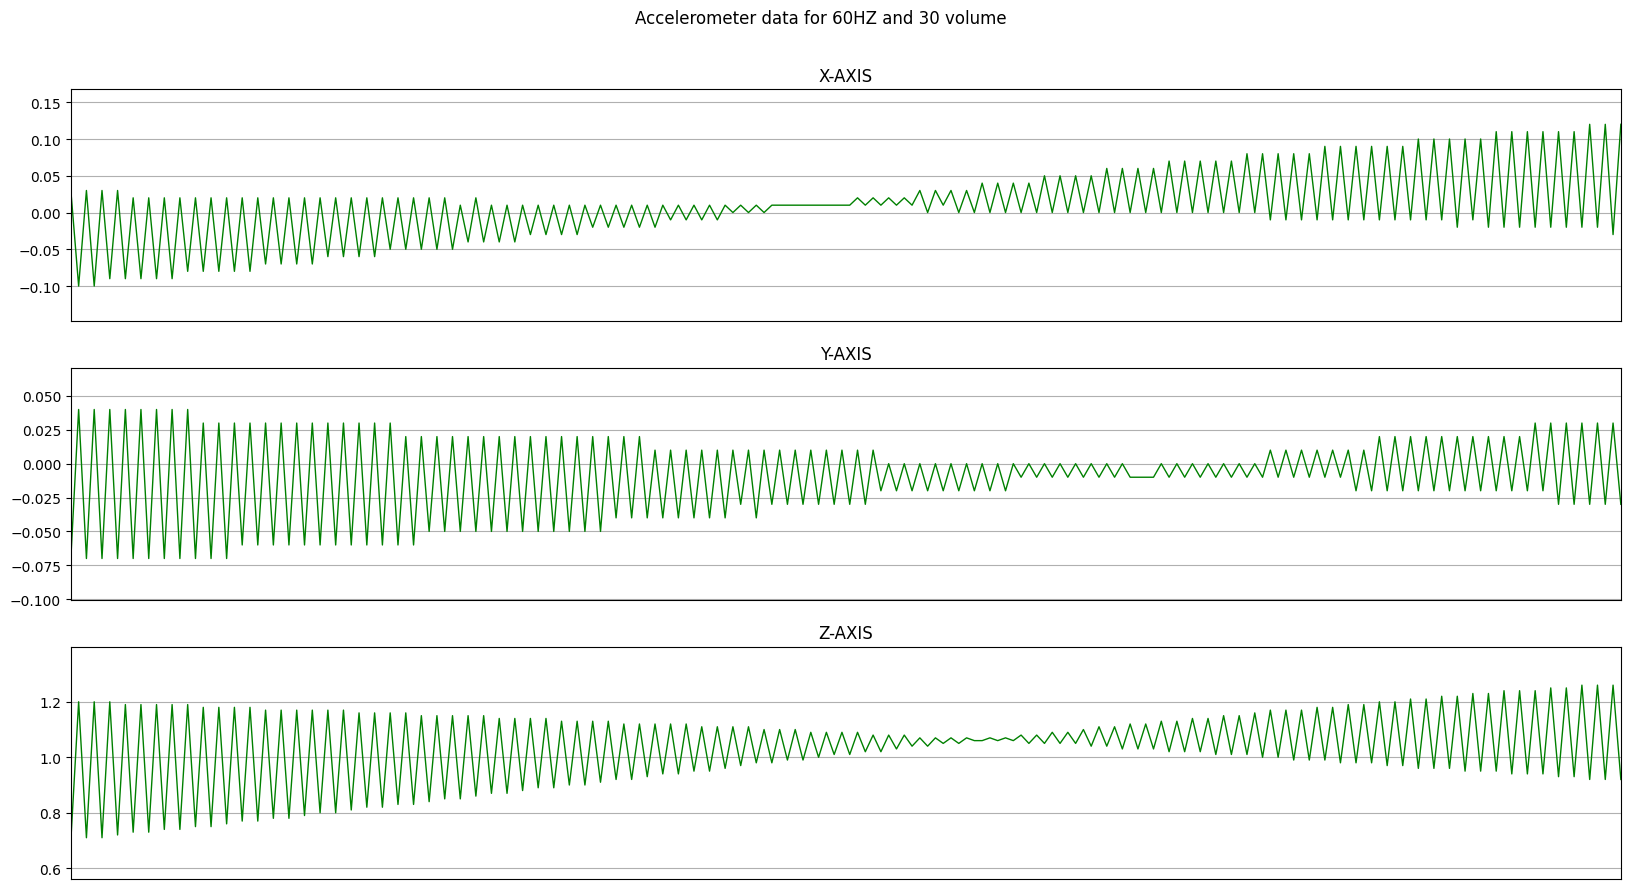

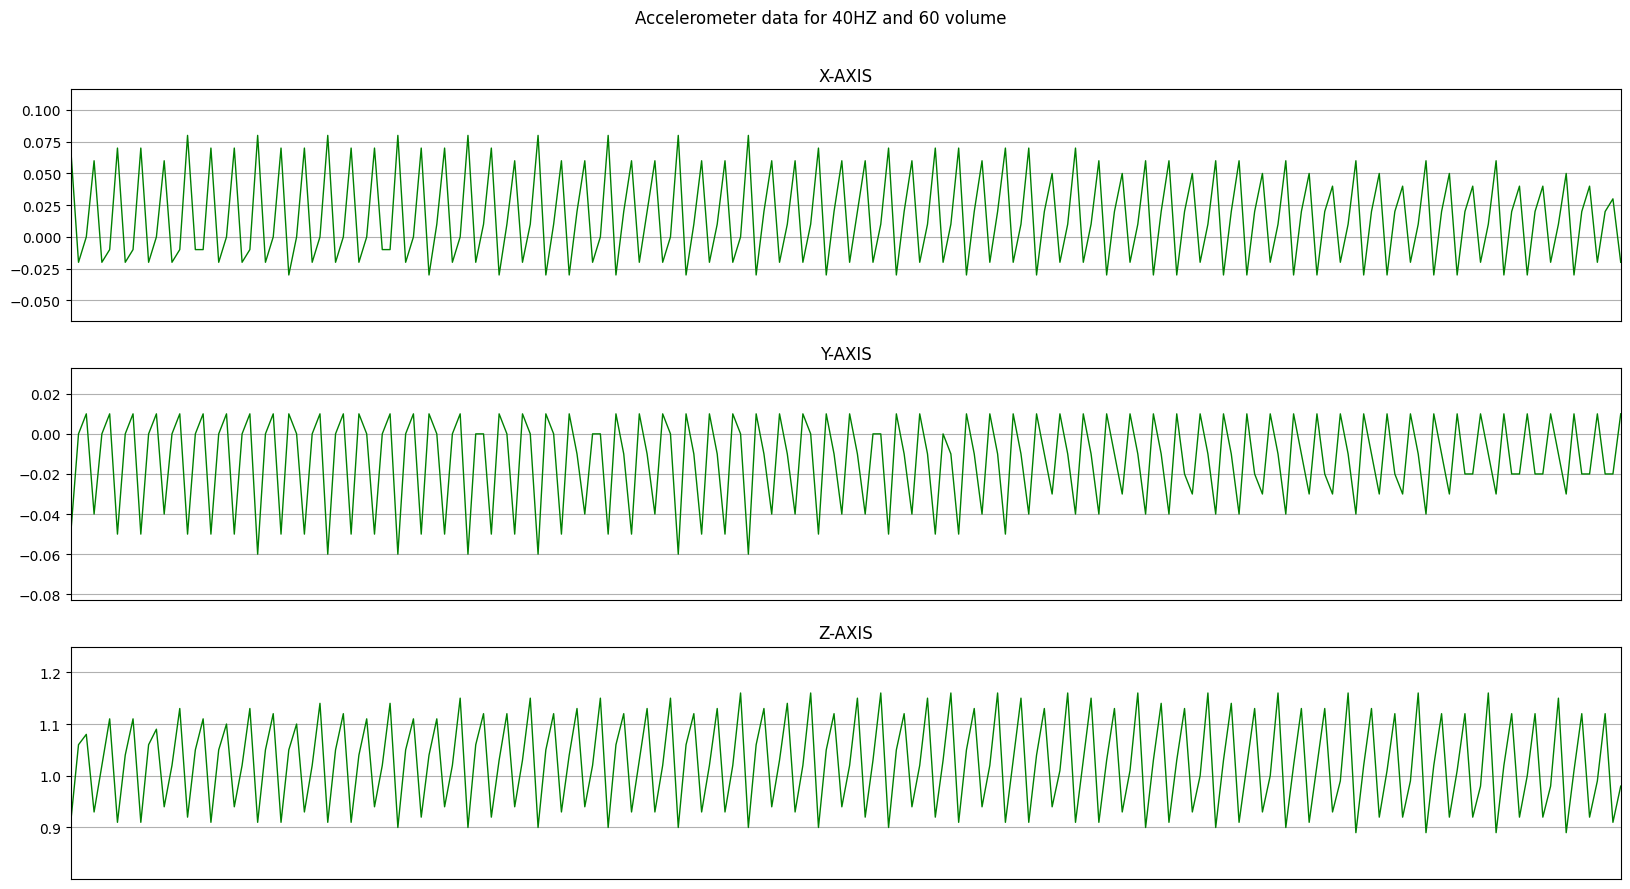

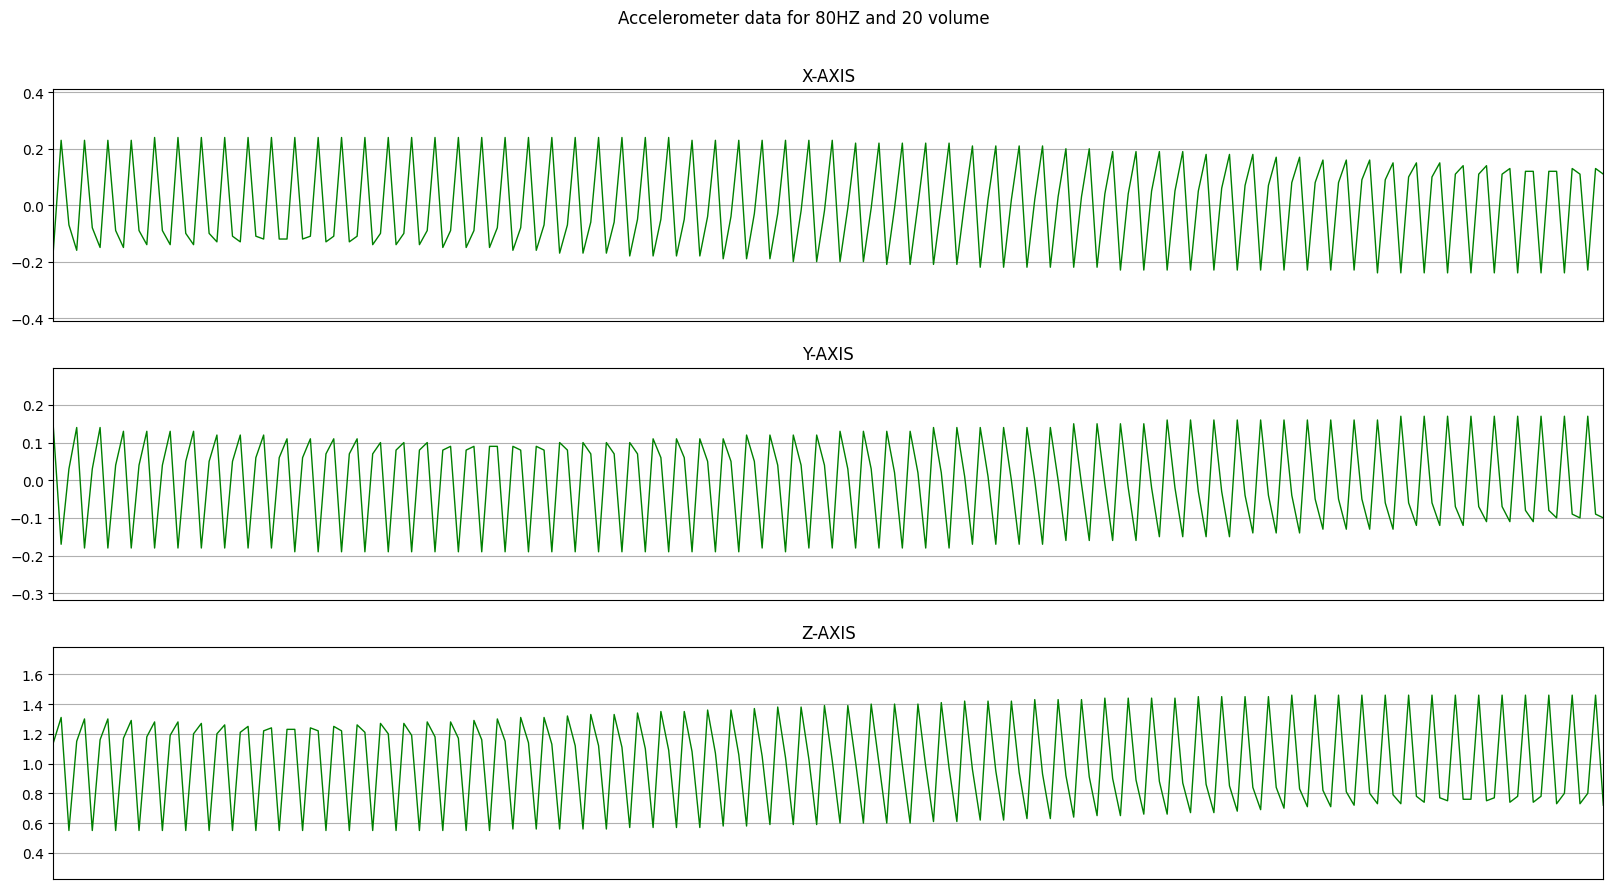

In [7]:
#select a subset of 2000 samples for plotting
subset_1 = dataset_1[:200]
plotVibPattern(subset_1, "60", "30")
subset_2 = dataset_2[:200]
plotVibPattern(subset_2, "40", "60")
subset_3 = dataset_3[:200]
plotVibPattern(subset_3, "80", "20")

### Pre-process the data

Before moving on to the NN part, we need to make sure that our data is pre-processed properly.

⚡Remember that every pre-processing step done here will have to be done when we deploy the model as well, so really think about the complexity of the steps that you are making here.

### Train test split

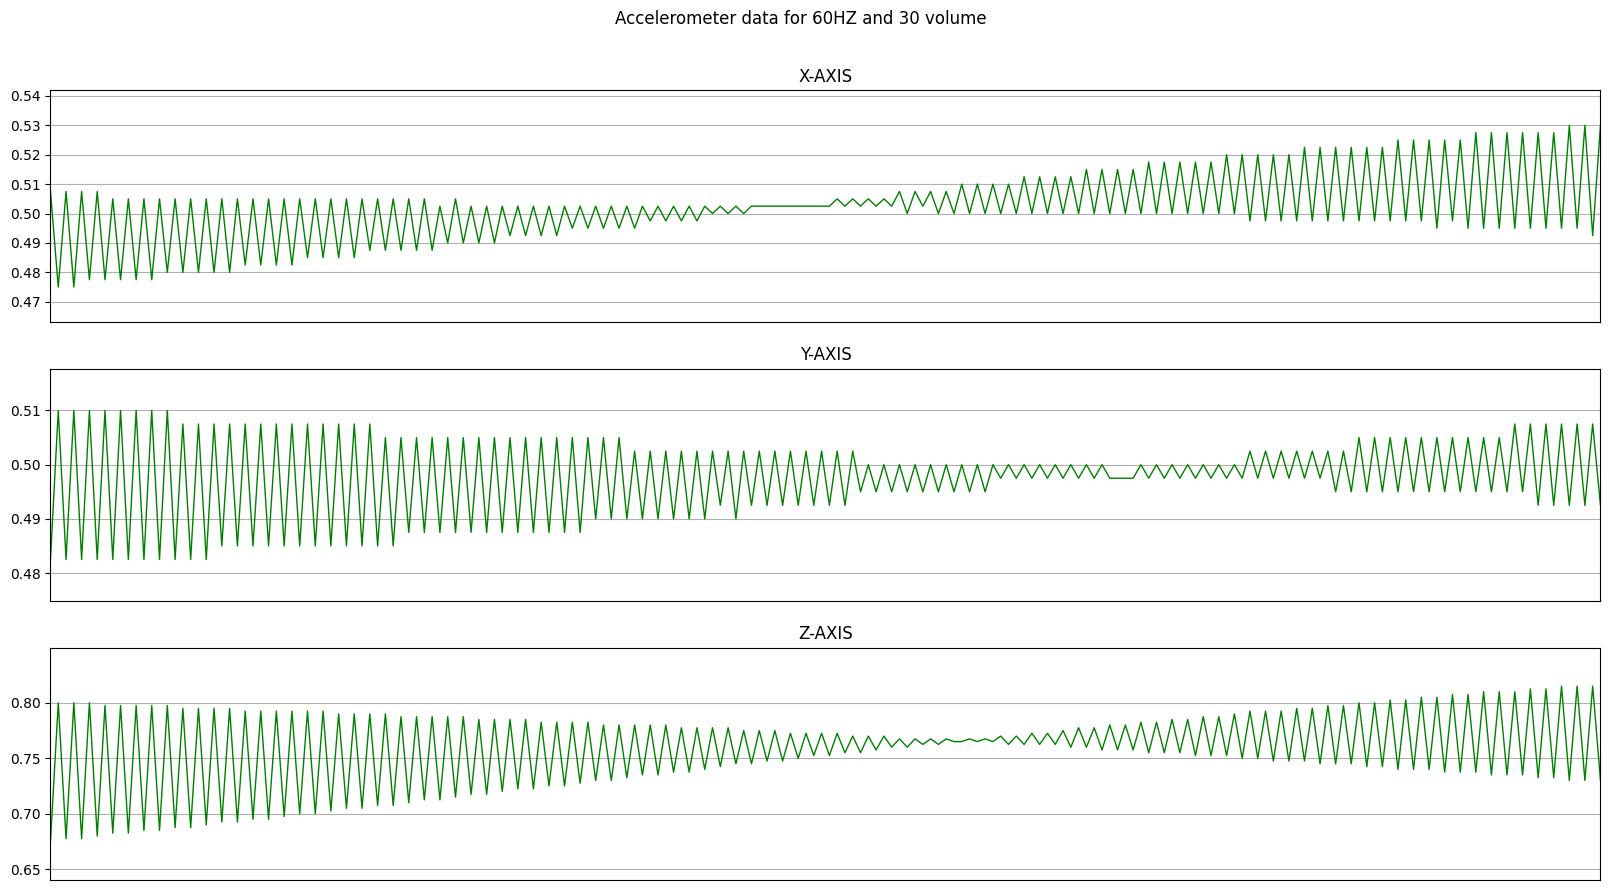

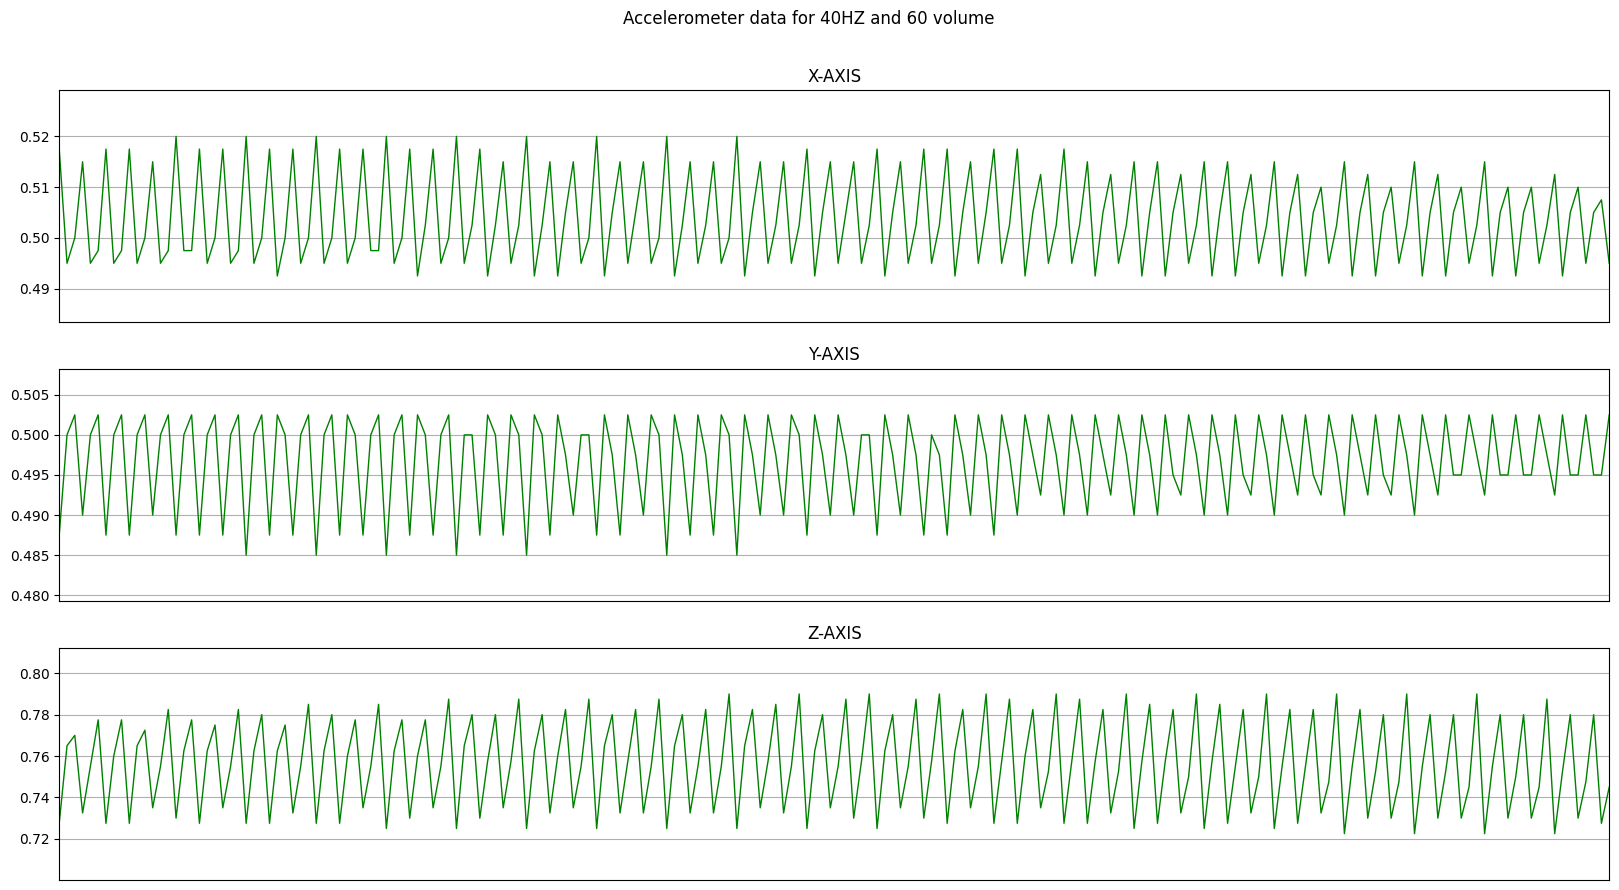

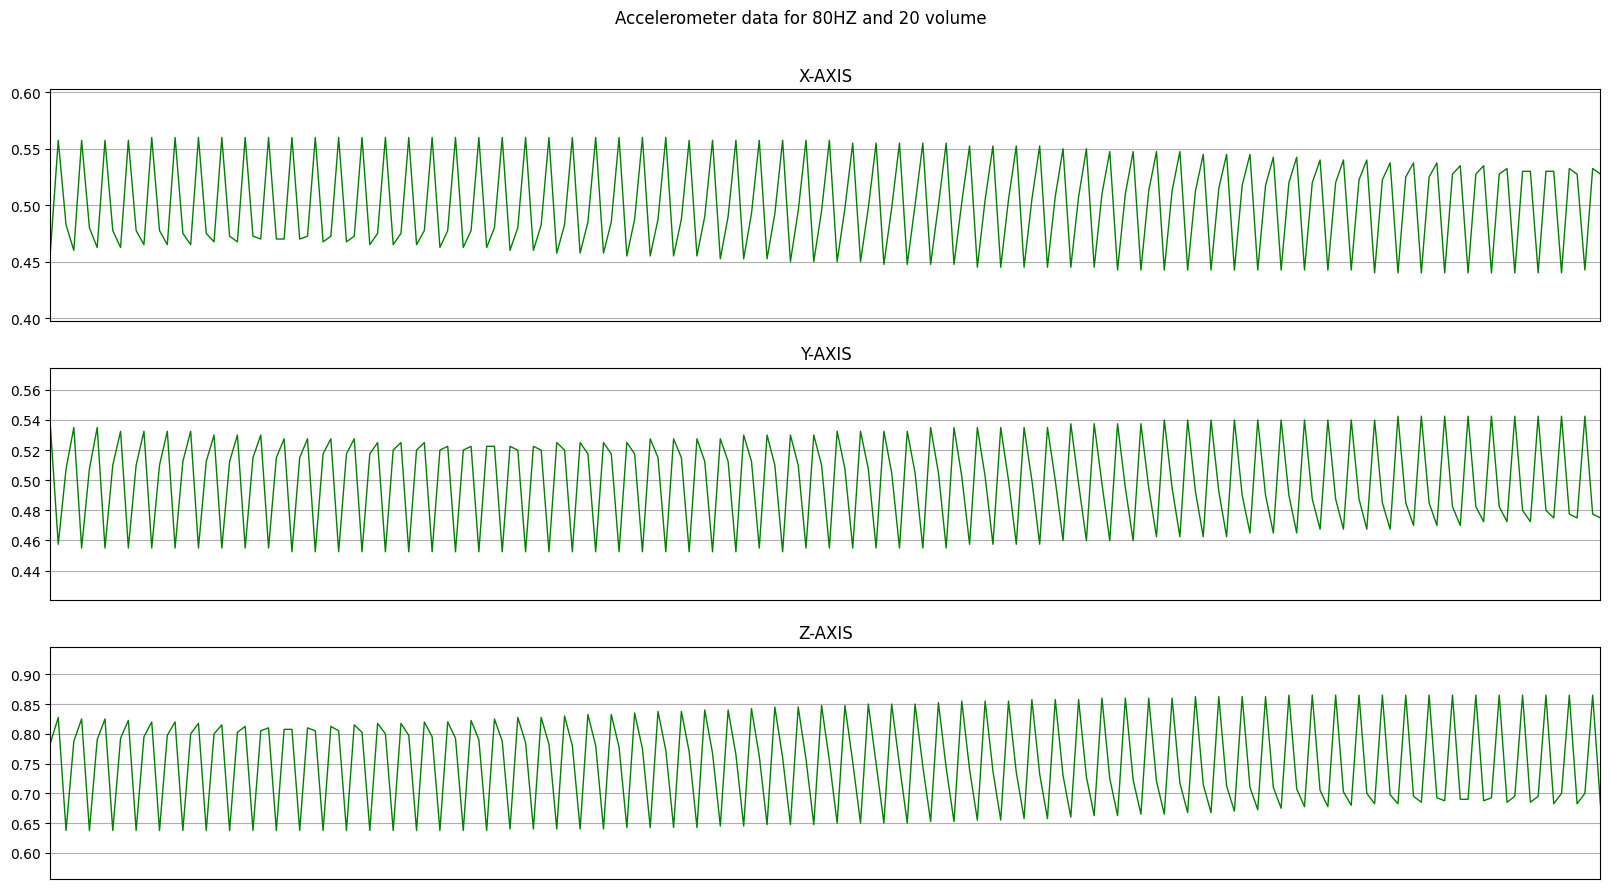

In [8]:
# Bring all values in the [0, 1] interval by  +2 /4

normalized_data1 = (dataset_1 + 2)/4
subset_1 = normalized_data1[:200]
plotVibPattern(subset_1, "60", "30")

normalized_data2 = (dataset_2 + 2)/4
subset_2 = normalized_data2[:200]
plotVibPattern(subset_2, "40", "60")

normalized_data3 = (dataset_3 + 2)/4
subset_3 = normalized_data3[:200]
plotVibPattern(subset_3, "80", "20")


First, we need to set aside some of our data for testing. We do this in order to be able to accurately report the performance of our model at the end. This means that we have to refrain from touching this data until the model is done!

We will keep thefirst 10% of the data from each condition for testing purposes. The following 90% will be used for training the model.

In [9]:
test_data_1 = normalized_data1[:int(normalized_data1.shape[0] * 10 / 100)]
test_data_2 = normalized_data2[:int(normalized_data2.shape[0] * 10 / 100)]
test_data_3 = normalized_data3[:int(normalized_data3.shape[0] * 10 / 100)]

train_data_1 = normalized_data1[int(normalized_data1.shape[0] * 10 / 100):]
train_data_2 = normalized_data2[int(normalized_data2.shape[0] * 10 / 100):]
train_data_3 = normalized_data3[int(normalized_data3.shape[0] * 10 / 100):]

Small check that we are not loosing / overlapping data:

In [10]:
print(train_data_1.shape[0] + test_data_1.shape[0] == dataset_1.shape[0])
print(train_data_2.shape[0] + test_data_2.shape[0] == dataset_2.shape[0])
print(train_data_3.shape[0] + test_data_3.shape[0] == dataset_3.shape[0])

True
True
True


### Creating segments

In order to make an inference, we will feed the network with 24 readings. The network will try to look for a pattern in the given segment and classify it in one of the 3 known classes, or label it us undefined if the confidence in the answer is too low.

To train such a model, we need to create such segments of data. They will each contain 24 readings and have 50% overlap with each other.

In [11]:
def windows(data,size):
    start = 0
    while start< data.count():
        yield int(start), int(start + size)
        start+= (size/2)

def split_data(data, window_size = 24):
    segments = np.empty((0,window_size,3))
    for (start, end) in windows(data['timestamp'],window_size):
        x = data['x-axis'][start:end]
        y = data['y-axis'][start:end]
        z = data['z-axis'][start:end]

        if(len(data['timestamp'][start:end])==window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
    return segments

In [12]:
segments_1 = split_data(train_data_1)
segments_2 = split_data(train_data_2)
segments_3 = split_data(train_data_3)

In [13]:
print("First class has a shape of ", segments_1.shape, "Second class has ", segments_2.shape, "and third ", segments_3.shape)

First class has a shape of  (2722, 24, 3) Second class has  (2705, 24, 3) and third  (2714, 24, 3)


In [14]:
merged_normalized_segments = np.concatenate([segments_1, segments_2, segments_3], axis=0)

In [15]:
merged_normalized_segments.shape

(8141, 24, 3)

We have 2722 segments of the first class, 2705 for the second and 2714 for the third. Together those will form our training dataset.

### Create a list of labels

Last but not least, we need to create lists that will hold the labels for the segments

😖: There is probably a smarter way to do this, but oh well...

The possible vibration patterns will be 0 (60Hz, 30vol), 1 (40Hz, 60vol) or 2 (80Hz, 20vol). labels_x hold those single digit labels for the segments.

To train the network we will want the labels to be represented as vectors, so we will use the one-hot-encoded representation of the labels (i.e. 0 is [1 0 0], 1 is [0 1 0] and 2 is [0 0 1]).

In [16]:
labels_1 = np.full(segments_1.shape[0], 0)
labels_2 = np.full(segments_2.shape[0], 1)
labels_3 = np.full(segments_3.shape[0], 2)

all_labels = np.concatenate((labels_1, labels_2, labels_3))
one_hot_encoded = np.asarray(pd.get_dummies(all_labels),dtype = np.int8)

one_hot_encoded_1 = one_hot_encoded[:segments_1.shape[0]]
one_hot_encoded_2 = one_hot_encoded[segments_1.shape[0]:(segments_1.shape[0] + segments_2.shape[0])]
one_hot_encoded_3 = one_hot_encoded[(segments_1.shape[0] + segments_2.shape[0]):]

labels = np.concatenate((one_hot_encoded_1, one_hot_encoded_2, one_hot_encoded_3))

In [17]:
labels

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=int8)

## Train a model on the normalized segmets, 3 classes

Now we can create our neural network that will classify the segments. For the task, we will use a Convolutional Neural Network that will take the 24x3 data segment and label it as one of the 3 possible classes.

The network will contain convolution layers, that will look for features in the data, as well as dense layers that will deal with the classification task itself.

In [18]:
#Convolutional Neural network model to train on the vibrational pattern
def TrainingModel():
    model = Sequential()
    # adding the first convolutionial layer with 24 filters and 2 by 1 kernal size, using the rectifier as the activation function
    model.add(Conv2D(8, (4,1),input_shape=(24, 3,1),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,1),strides=(2,1),padding='valid'))
    model.add(Flatten())
    # adding the dropout layer to avoid overfitting
    model.add(Dropout(0.3))
    # adding softmax layer for the classification
    model.add(Dense(3, activation='softmax'))
    # Compiling the model to generate a model
    adam = optimizers.Adam()
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()
    return model

In [19]:
# shuffle the data a bit: merged_normalized_segments and labels need shuffling in unison

# Shuffle two lists with same order
# Using zip() + * operator + shuffle()
temp = list(zip(merged_normalized_segments, labels))
random.shuffle(temp)
res1, res2 = zip(*temp)
# res1 and res2 come out as tuples, and so must be converted to lists.
res1, res2 = np.array(res1), np.array(res2)

In [20]:
model = TrainingModel()
history = model.fit(res1, res2, validation_split=0.2,epochs=10,batch_size=5, shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 3, 8)          40        
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 3, 8)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 240)               0         
                                                                 
 dropout (Dropout)           (None, 240)               0         
                                                                 
 dense (Dense)               (None, 3)                 723       
                                                                 
Total params: 763 (2.98 KB)
Trainable params: 763 (2.98 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________

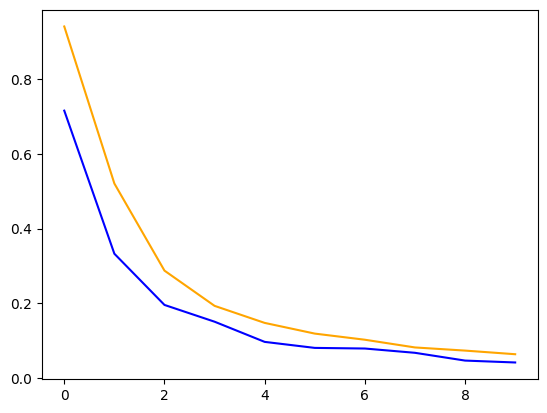

In [21]:
plt.plot(history.history['loss'], color='orange')
plt.plot(history.history['val_loss'], 'b')

## Testing on the set-aside test data

Now we will create segments (with no overlap, but normalized) from the test data we set aside at the beginning. Let's see how the model will perform.

In [22]:
# Create segments from the test data
def windows(data,size):
    start = 0
    while start< data.count():
        yield int(start), int(start + size)
        start+= size

def split_data(data, window_size = 24):
    segments = np.empty((0,window_size,3))
    #labels= np.empty((0))
    for (start, end) in windows(data['timestamp'],window_size):
        x = data['x-axis'][start:end]
        y = data['y-axis'][start:end]
        z = data['z-axis'][start:end]

        if(len(data['timestamp'][start:end])==window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            #labels = np.append(labels,l)
    return segments#, labels

test_segments_1 = split_data(test_data_1)
test_segments_2 = split_data(test_data_2)
test_segments_3 = split_data(test_data_3)
test_normalized_segments = np.concatenate((test_segments_1, test_segments_2, test_segments_3))

In [23]:
test_normalized_segments.shape

(451, 24, 3)

In [24]:
test_labels_1 = np.full(test_segments_1.shape[0], 0)
test_labels_2 = np.full(test_segments_2.shape[0], 1)
test_labels_3 = np.full(test_segments_3.shape[0], 2)

test_all_labels = np.concatenate((test_labels_1, test_labels_2, test_labels_3))
test_one_hot_encoded = np.asarray(pd.get_dummies(test_all_labels),dtype = np.int8)

test_one_hot_encoded_1 = test_one_hot_encoded[:test_segments_1.shape[0]]
test_one_hot_encoded_2 = test_one_hot_encoded[test_segments_1.shape[0]:(test_segments_1.shape[0] + test_segments_2.shape[0])]
test_one_hot_encoded_3 = test_one_hot_encoded[(test_segments_1.shape[0] + test_segments_2.shape[0]):]

test_labels = np.concatenate((test_one_hot_encoded_1, test_one_hot_encoded_2, test_one_hot_encoded_3))

In [25]:
test_labels.shape

(451, 3)

In [26]:
loss_100, accuracy_100 = model.evaluate(test_normalized_segments, test_labels)

15/15 [==============================] - 0s 3ms/step - loss: 0.0584 - accuracy: 0.9756


In [27]:
predicted_labels = []
for one_seg in test_normalized_segments:
  predicted_label = model.predict(np.expand_dims(one_seg, axis = 0))
  predicted_labels.append(np.argmax(predicted_label))

1/1 [==============================] - 0s 19ms/step


In [28]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(test_all_labels, predicted_labels)


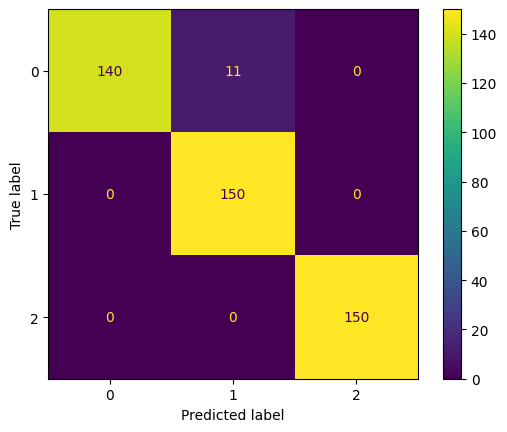

In [29]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [30]:
metrics.accuracy_score(test_all_labels, predicted_labels)

0.975609756097561

In [31]:
model.save("saved_model/my_model")

I want to test the model with the slice of data that I'll use for the single inference on the board to see where stuff goes wrong:

In [ ]:
# labels = model.predict(np.expand_dims(test_normalized_segments[50], axis = 0))
# np.argmax(labels)

In [ ]:
# normalized_segments_2[50]

Looks fine. You can try with normalized_segments 1 or 2 and the labels will be 0 or 1 respectively.

Perform a simple conversion to TF Lite in order to visualize the model and see what tf Im doing

In [32]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/my_model")
tflite_model = converter.convert()

# Save the model.
with open('cnn.tflite', 'wb') as f:
  f.write(tflite_model)

I downloaded the .tflite file and uploaded it to https://netron.app/ in order to visualize the architecture of the model.

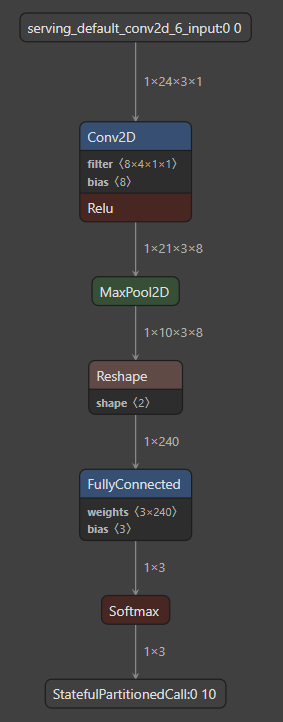

Inspect the size of the model

**The Arduino Nano 33 BLE Sense has 1 MB Flash + 256 KB RAM.**

In [33]:
tf.lite.experimental.Analyzer.analyze(model_path="cnn.tflite",
                                      model_content=None,
                                      gpu_compatibility=False)

=== cnn.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the CONV_2D op takes
tensor #0 and tensor #2 and tensor #1 as input and produces tensor #6 as output.

Subgraph#0 main(T#0) -> [T#10]
  Op#0 CONV_2D(T#0, T#2, T#1) -> [T#6]
  Op#1 MAX_POOL_2D(T#6) -> [T#7]
  Op#2 RESHAPE(T#7, T#4[-1, 240]) -> [T#8]
  Op#3 FULLY_CONNECTED(T#8, T#5, T#3) -> [T#9]
  Op#4 SOFTMAX(T#9) -> [T#10]

Tensors of Subgraph#0
  T#0(serving_default_conv2d_input:0) shape_signature:[-1, 24, 3, 1], type:FLOAT32
  T#1(sequential/conv2d/BiasAdd/ReadVariableOp) shape:[8], type:FLOAT32 RO 32 bytes, buffer: 2, data:[0.106862, 0, -0.00242781, 0, -0.0155821, ...]
  T#2(sequential/conv2d/Conv2D) shape:[8, 4, 1, 1], type:FLOAT32 RO 128 bytes, buffer: 3, data:[0.244064, 0.24646, 0.242282, -0.00193513, -0.339946, ...]
  T#3(sequential/dense/BiasAdd/ReadVariableOp) shape:[3], type:FLOAT32 RO 12 bytes, buffer: 4, data:[-0.164888

In [34]:
# SAVE NON-QUANTIZED MODEL

!apt-get update && apt-get -qq install xxd

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [917 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,439 kB]
Get:13 http://security.u

In [35]:
MODEL_TFLITE = 'cnn.tflite'
MODEL_TFLITE_MICRO = 'cnn.cc'
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

# Code for quantizing models & experimenting - STOP HERE

In [ ]:
input_data = [
    [-0.13, 0.07, 0.55],
    [-0.11, 0.11, 1.25],
    [0.24, -0.19, 1.22],
    [-0.13, 0.07, 0.55],
    [-0.11, 0.11, 1.26],
    [0.24, -0.19, 1.21],
    [-0.14, 0.07, 0.55],
    [-0.10, 0.10, 1.27],
    [0.24, -0.19, 1.20],
    [-0.14, 0.08, 0.55],
    [-0.10, 0.10, 1.27],
    [0.24, -0.19, 1.19],
    [-0.14, 0.08, 0.55],
    [-0.09, 0.10, 1.28],
    [0.24, -0.19, 1.18],
    [-0.15, 0.08, 0.55],
    [-0.09, 0.09, 1.28],
    [0.24, -0.19, 1.17],
    [-0.15, 0.08, 0.55],
    [-0.09, 0.09, 1.29],
    [0.24, -0.19, 1.16],
    [-0.15, 0.09, 0.55],
    [-0.08, 0.09, 1.30],
    [0.24, -0.19, 1.15]
]


In [ ]:
input_data_test = np.array(input_data)

input_data_test = (input_data_test + 2)/4

In [ ]:
input_data_test.shape

(24, 3)

In [ ]:
test_normalized_segments[0].shape

(24, 3)

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="cnn.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
#input_data = np.array(test_normalized_segments, dtype=np.float32)
test_quantized = tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(input_data_test, dtype=tf.float32), -1), 0)

input_data = test_quantized# = tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(normalized_segments_3[2], dtype=tf.float32), -1), 0)

interpreter.set_tensor(input_details[0]['index'], input_data)


interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)
print(np.argmax(output_data))

[[5.2490725e-07 2.8690754e-04 9.9971265e-01]]
2


In [ ]:
test_normalized_segments[1]

array([[0.505 , 0.485 , 0.6925],
       [0.4825, 0.5075, 0.7925],
       [0.505 , 0.485 , 0.695 ],
       [0.4825, 0.5075, 0.7925],
       [0.505 , 0.485 , 0.695 ],
       [0.4825, 0.5075, 0.7925],
       [0.505 , 0.485 , 0.6975],
       [0.4825, 0.5075, 0.7925],
       [0.505 , 0.485 , 0.7   ],
       [0.485 , 0.5075, 0.7925],
       [0.505 , 0.485 , 0.7   ],
       [0.485 , 0.5075, 0.7925],
       [0.505 , 0.485 , 0.7025],
       [0.485 , 0.5075, 0.79  ],
       [0.505 , 0.485 , 0.705 ],
       [0.485 , 0.5075, 0.79  ],
       [0.505 , 0.485 , 0.705 ],
       [0.4875, 0.5075, 0.79  ],
       [0.505 , 0.485 , 0.7075],
       [0.4875, 0.505 , 0.79  ],
       [0.505 , 0.485 , 0.7075],
       [0.4875, 0.505 , 0.7875],
       [0.505 , 0.4875, 0.71  ],
       [0.4875, 0.505 , 0.7875]])

Running one inference with the (now saved) model seems fine (?)

## **[Stopped here, we do not use the quantized model as the one we got is small enough]** Quantize the model


test_normalized_segments - the test inputs, numpy array, (451, 24, 3)

test_labels - the expected outputs, numpy.ndarray, (451, 3)


In [ ]:
def representative_data_gen():
    for input_value in test_normalized_segments:
        yield tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(input_value, dtype=tf.float32), -1), 0)

In [ ]:
data = representative_data_gen()

In [ ]:
for d in data:
  break
d.shape

TensorShape([1, 24, 3, 1])

In [ ]:
model.predict(d)

1/1 [==============================] - 0s 66ms/step


array([[1.000000e+00, 7.608961e-09, 0.000000e+00]], dtype=float32)

I want to test with my chosen segment again:

In [ ]:
test_quantized = tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(normalized_segments_3[2], dtype=tf.float32), -1), 0)
test_quantized.shape

TensorShape([1, 24, 3, 1])

In [ ]:
qunatized_test_labels = model.predict(test_quantized)

1/1 [==============================] - 0s 46ms/step


In [ ]:
np.argmax(qunatized_test_labels)

2

Still looks good - also the probabilities look the same

In [ ]:
interpreter = tf.lite.Interpreter(model_content = tflite_model)
print(interpreter.get_signature_list())

{'serving_default': {'inputs': ['conv2d_input'], 'outputs': ['dense']}}


In [ ]:
####### https://blog.tensorflow.org/2021/03/a-tour-of-savedmodel-signatures.html
###### https://www.tensorflow.org/lite/performance/post_training_quantization


# Save the model as a SavedModel
tf.saved_model.save(model, 'saved_model')

# Convert the SavedModel to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]


# Convert your DataFrame to a TensorFlow Dataset
#test_dataset = tf.data.Dataset.from_tensor_slices(test_normalized_segments.values)

# Define the batch size
batch_size = 32

def representative_data_gen():
    for input_value in test_normalized_segments:
        #yield tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(input_value, dtype=tf.float32), -1), 0)
        yield {"conv2d_input": tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(input_value, dtype=tf.float32), -1), 0)}

'''
# Code from EDX Tiny ML fundamentals course
def representative_data_gen():
    for input_value in test_batch.take(100):
        yield [tf.cast(input_value, tf.float32)]  # Convert to FLOAT32]
'''

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]


# Save the TensorFlow Lite model
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

In [ ]:
tf.lite.experimental.Analyzer.analyze(model_path="converted_model.tflite",
                                      model_content=None,
                                      gpu_compatibility=False)

=== converted_model.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the QUANTIZE op takes
tensor #0 as input and produces tensor #6 as output.

Subgraph#0 main(T#0) -> [T#12]
  Op#0 QUANTIZE(T#0) -> [T#6]
  Op#1 CONV_2D(T#6, T#5, T#4[6240, -2215, -42683, 4879, 3026, ...]) -> [T#7]
  Op#2 MAX_POOL_2D(T#7) -> [T#8]
  Op#3 RESHAPE(T#8, T#1[-1, 240]) -> [T#9]
  Op#4 FULLY_CONNECTED(T#9, T#3, T#2[103, 3178, -2626]) -> [T#10]
  Op#5 SOFTMAX(T#10) -> [T#11]
  Op#6 DEQUANTIZE(T#11) -> [T#12]

Tensors of Subgraph#0
  T#0(serving_default_conv2d_input:0) shape_signature:[-1, 24, 3, 1], type:FLOAT32
  T#1(sequential/flatten/Const) shape:[2], type:INT32 RO 8 bytes, buffer: 2, data:[-1, 240]
  T#2(sequential/dense/BiasAdd/ReadVariableOp) shape:[3], type:INT32 RO 12 bytes, buffer: 3, data:[103, 3178, -2626]
  T#3(sequential/dense/MatMul) shape:[3, 240], type:INT8 RO 720 bytes, buffer: 4, data:[>, ., .,

In [ ]:
!apt-get update && apt-get -qq install xxd

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [50.5 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,624 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,650 kB]
Get:13 ht

In [ ]:
MODEL_TFLITE = 'autoencoder.tflite'
MODEL_TFLITE_MICRO = 'autoencoder.cc'
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

In [ ]:
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x88, 0x00, 0x00, 0x00, 0xe0, 0x00, 0x00, 0x00, 0x24, 0x05, 0x00, 0x00,
  0x34, 0x05, 0x00, 0x00, 0xa4, 0x0e, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xf6, 0xf9, 0xff, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x94, 0xff, 0xff, 0xff, 0x0c, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x05, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x96, 0xfa, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x63, 0x

In [ ]:
dataset_1 = readData("capture1_60hz_30vol.txt")
normalized_data1 = (dataset_1 + 2)/4


In [ ]:
normalized_data1[0:96]

,x-axis,y-axis,z-axis
0,0.5075,0.4825,0.6750
1,0.4750,0.5100,0.8000
2,0.5075,0.4825,0.6775
3,0.4750,0.5100,0.8000
4,0.5075,0.4825,0.6775
...,...,...,...
91,0.5025,0.5025,0.7750
92,0.5025,0.4925,0.7475
93,0.5025,0.5025,0.7750
94,0.5025,0.4925,0.7475


In [ ]:
test = normalized_data1[0:96]
input_data_test = test.to_numpy()
input_data_test = input_data_test.flatten()

In [ ]:
input_data_test.shape

(288,)

In [ ]:
input_data_test

array([0.5075, 0.4825, 0.675 , 0.475 , 0.51  , 0.8   , 0.5075, 0.4825,
       0.6775, 0.475 , 0.51  , 0.8   , 0.5075, 0.4825, 0.6775, 0.4775,
       0.51  , 0.8   , 0.5075, 0.4825, 0.68  , 0.4775, 0.51  , 0.7975,
       0.505 , 0.4825, 0.6825, 0.4775, 0.51  , 0.7975, 0.505 , 0.4825,
       0.6825, 0.4775, 0.51  , 0.7975, 0.505 , 0.4825, 0.685 , 0.4775,
       0.51  , 0.7975, 0.505 , 0.4825, 0.685 , 0.48  , 0.51  , 0.7975,
       0.505 , 0.4825, 0.6875, 0.48  , 0.5075, 0.795 , 0.505 , 0.4825,
       0.6875, 0.48  , 0.5075, 0.795 , 0.505 , 0.4825, 0.69  , 0.48  ,
       0.5075, 0.795 , 0.505 , 0.485 , 0.6925, 0.48  , 0.5075, 0.795 ,
       0.505 , 0.485 , 0.6925, 0.4825, 0.5075, 0.7925, 0.505 , 0.485 ,
       0.695 , 0.4825, 0.5075, 0.7925, 0.505 , 0.485 , 0.695 , 0.4825,
       0.5075, 0.7925, 0.505 , 0.485 , 0.6975, 0.4825, 0.5075, 0.7925,
       0.505 , 0.485 , 0.7   , 0.485 , 0.5075, 0.7925, 0.505 , 0.485 ,
       0.7   , 0.485 , 0.5075, 0.7925, 0.505 , 0.485 , 0.7025, 0.485 ,
      

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="autoencoder_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
#input_data = np.array(test_normalized_segments, dtype=np.float32)
#test_quantized = tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(input_data_test, dtype=tf.float32), -1), 0)
test_quantized = tf.expand_dims(tf.convert_to_tensor(input_data_test, dtype=tf.float32), 0)

input_data = test_quantized# = tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(normalized_segments_3[2], dtype=tf.float32), -1), 0)

interpreter.set_tensor(input_details[0]['index'], input_data)


interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)
#print(np.argmax(output_data))

[[0.50711656 0.4831831  0.67904425 0.47509548 0.51032    0.8015075
  0.50642884 0.4821385  0.68123925 0.47602287 0.5089232  0.8016343
  0.5059285  0.48277083 0.68214655 0.47623715 0.5098851  0.8011435
  0.50585663 0.48279324 0.6834022  0.47707522 0.50935125 0.8013842
  0.50570756 0.48360988 0.68468225 0.4773544  0.5092455  0.8007101
  0.50559664 0.48396996 0.68650013 0.47726044 0.50920993 0.7998504
  0.5055862  0.48403424 0.688495   0.4788002  0.5082736  0.79960704
  0.505474   0.48427513 0.68951327 0.48016834 0.50781    0.79931194
  0.5056797  0.4841618  0.6912372  0.4794925  0.5078185  0.79922473
  0.5052297  0.4843759  0.6926367  0.48007745 0.5078786  0.79814094
  0.50499165 0.4848671  0.6946945  0.48120087 0.5076984  0.7979055
  0.5048678  0.48494542 0.6959022  0.48170558 0.5075746  0.7969867
  0.5041621  0.48512068 0.69821995 0.4827683  0.5076606  0.79702246
  0.503824   0.48569244 0.69948894 0.4837529  0.50658697 0.79653555
  0.50381887 0.4861335  0.701059   0.48327494 0.50637615

In [ ]:
mae = np.mean(np.abs(output_data - input_data_test))
mae

0.002643453209764424

In [ ]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 29,
  'shape': array([  1, 288], dtype=int32),
  'shape_signature': array([ -1, 288], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

So I want to see those 3 numbers when deploying the code.

In [ ]:
input_normalized = [
    0.49682617, 0.50497437, 0.87054443, 0.46594238, 0.46533203, 0.70166016,
    0.44525146, 0.49438477, 0.67065430, 0.52258301, 0.50964355, 0.89700317,
    0.42044067, 0.47564697, 0.63101196, 0.46542358, 0.50286865, 0.78634644,
    0.50701904, 0.48150635, 0.81298828, 0.42361450, 0.48031616, 0.61300659,
    0.49868774, 0.50555420, 0.87463379, 0.46347046, 0.46545410, 0.69503784,
    0.44641113, 0.49459839, 0.67675781, 0.52301025, 0.50888062, 0.89602661,
    0.42047119, 0.47573853, 0.62756348, 0.46746826, 0.50369263, 0.79470825,
    0.50537109, 0.47802734, 0.80441284, 0.42703247, 0.48056030, 0.61257935,
    0.50054932, 0.50656128, 0.87774658, 0.45950317, 0.46569824, 0.69042969,
    0.44760132, 0.49588013, 0.68231201, 0.52355957, 0.50851440, 0.89349365,
    0.41824341, 0.47625732, 0.62561035, 0.46893311, 0.50445557, 0.80032349,
    0.50360107, 0.47726440, 0.79510498, 0.42669678, 0.48120117, 0.61782837
]

output_normalized = [
    0.48188922, 0.51075280, 0.87157530, 0.48083836, 0.48612747, 0.72079635,
    0.43637800, 0.47812024, 0.68272978, 0.49793333, 0.51409936, 0.87751901,
    0.44689515, 0.47569698, 0.60076416, 0.45919719, 0.49875623, 0.79313844,
    0.49600318, 0.49600518, 0.82290870, 0.42808902, 0.47147980, 0.59831727,
    0.48285306, 0.51159614, 0.87427795, 0.47965908, 0.48562023, 0.71270275,
    0.43789896, 0.48176169, 0.69076157, 0.49835297, 0.51301426, 0.88056046,
    0.44421783, 0.47602183, 0.59707642, 0.46095067, 0.50067568, 0.79960012,
    0.49381179, 0.49551129, 0.81206071, 0.42850721, 0.47055677, 0.60055351,
    0.48402035, 0.51242566, 0.87471831, 0.47903800, 0.48475054, 0.70542508,
    0.44148564, 0.48176235, 0.69909227, 0.49752390, 0.51006085, 0.87877393,
    0.44349226, 0.47556332, 0.59301871, 0.46228927, 0.50159448, 0.80769658,
    0.49346077, 0.49454385, 0.81075531, 0.42778608, 0.47152436, 0.60442734
]


In [ ]:
import numpy


inp = numpy.array(input_normalized)
out = numpy.array(output_normalized)

In [ ]:
mae = numpy.mean(numpy.abs(inp - out))

In [ ]:
mae


0.01230090666666667